In [1]:
##### Develop a RL based system for assisting cab drivers to maximizing their profits on daily trips.
##### Submitted by 
##### Aman Srivastava - amanit0812@gmail.com
##### Nurul Quamar Khan - noor.025@gmail.com
##### Harish Kumar  - harishragp@gmail.com
##### Prakash Srinivasan  - Prakash.Srinivasan@techmahindra.com

###  Importing libraries

In [2]:
# Importing libraries
import numpy as np
import random
import math
import collections
import pickle
import os

from collections import deque

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
states_track = collections.defaultdict(dict)

def initialise_states_for_tracking():
    #select any 5  Q-values
    sample_q_values = [((4,3,2),(4,1)),((3,4,2),(2,3)),((2,2,2),(3,2)),((1,22,4),(1,3)), ((4,24,3),(3,4))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        #this is an array which will have appended values of that state-action pair for every 25th episode         
        states_track[state][action] = []    


In [4]:
initialise_states_for_tracking()

In [5]:
def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            action_index = env.action_space.index(action_list)
            Q = prediction[0][action_index]
            states_track[state][action].append(Q)  

###  CabDrive Agent

In [6]:
m = 5 
t = 24  
d = 7   
class DQNAgent:
    def __init__(self, state_size, action_size):

        # Define size of state and action
        self.state_size = m+t+d 
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]
      
        # These are hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(200, input_dim = self.state_size,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(self.action_size,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, episode):
    # get action from model using epsilon-greedy policy
    # Decay in e after we generate each sample from the environment
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
    
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            state_encod = env.state_trans(state)
            state_encod = np.reshape(state_encod, [1, self.state_size])
            q_value = self.model.predict(state_encod)
            q_value = q_value[0][poss_actions_index]
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
            
        return action, epsilon
        
        
    # save sample <s,a,r,s'> to the replay memory 
    def append_sample(self, state, action, reward, next_state, terminal_state):
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_output = np.zeros((self.batch_size, self.state_size))
        update_input = np.zeros((self.batch_size, self.state_size))

        actions, rewards, terminal_states = [], [], []
       
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_trans(state)
            update_output[i] = env.state_trans(next_state)
                
        target = self.model.predict(update_input)
        target_val = self.model.predict(update_output)
        
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                   
    def save(self, name):
        self.model.save_weights(name)

In [7]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [8]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")
    
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)
action_space = env.action_space
Time_matrix = np.load("TM.npy")

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []


Episodes = 20000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards for every 25th episode
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode,"  no of steps:",step_count, "  score:", tot_reward, "  avg score:", round(tot_reward/step_count,4),
                  "  memorylength:", len(agent.memory), "  epsilon:", epsilon)
            
    #For every 25th episode,track the states.
    if episode % 25 == 0:   #every 25 episode
        save_tracking_states()

    if episode % 10000 ==0 and episode !=0:
        Rewardname = "saved_pickle_files/Rewards"+str(episode)
        Statesname = "saved_pickle_files/States_tracked"+str(episode)
        save_obj(avg_reward,Rewardname)  
        save_obj(states_track,Statesname)
        agent.save("./cab_driver.h5")


episode: 0   no of steps: 145   score: -47.0   avg score: -0.3241   memorylength: 145   epsilon: 1.0
episode: 25   no of steps: 137   score: 57.0   avg score: 0.4161   memorylength: 2000   epsilon: 0.9925280548938579
episode: 50   no of steps: 154   score: -78.0   avg score: -0.5065   memorylength: 2000   epsilon: 0.9851119397519432
episode: 75   no of steps: 146   score: -642.0   avg score: -4.3973   memorylength: 2000   epsilon: 0.9777512374158239
episode: 100   no of steps: 132   score: -236.0   avg score: -1.7879   memorylength: 2000   epsilon: 0.9704455338440529
episode: 125   no of steps: 148   score: 72.0   avg score: 0.4865   memorylength: 2000   epsilon: 0.9631944180888776
episode: 150   no of steps: 146   score: -389.0   avg score: -2.6644   memorylength: 2000   epsilon: 0.9559974822731252
episode: 175   no of steps: 139   score: -297.0   avg score: -2.1367   memorylength: 2000   epsilon: 0.948854321567258
episode: 200   no of steps: 147   score: -361.0   avg score: -2.4558  

episode: 1750   no of steps: 121   score: 90.0   avg score: 0.7438   memorylength: 2000   epsilon: 0.5915553684512614
episode: 1775   no of steps: 139   score: 336.0   avg score: 2.4173   memorylength: 2000   epsilon: 0.5871352992414688
episode: 1800   no of steps: 150   score: 212.0   avg score: 1.4133   memorylength: 2000   epsilon: 0.5827482565465072
episode: 1825   no of steps: 135   score: 199.0   avg score: 1.4741   memorylength: 2000   epsilon: 0.5783939935940685
episode: 1850   no of steps: 137   score: 254.0   avg score: 1.854   memorylength: 2000   epsilon: 0.5740722654557134
episode: 1875   no of steps: 146   score: 569.0   avg score: 3.8973   memorylength: 2000   epsilon: 0.5697828290330947
episode: 1900   no of steps: 128   score: 253.0   avg score: 1.9766   memorylength: 2000   epsilon: 0.5655254430442828
episode: 1925   no of steps: 120   score: 252.0   avg score: 2.1   memorylength: 2000   epsilon: 0.5612998680101929
episode: 1950   no of steps: 161   score: 283.0   avg

episode: 3475   no of steps: 132   score: 606.0   avg score: 4.5909   memorylength: 2000   epsilon: 0.3525721553541629
episode: 3500   no of steps: 131   score: 385.0   avg score: 2.9389   memorylength: 2000   epsilon: 0.3499377556117779
episode: 3525   no of steps: 134   score: 874.0   avg score: 6.5224   memorylength: 2000   epsilon: 0.34732303995985236
episode: 3550   no of steps: 146   score: 656.0   avg score: 4.4932   memorylength: 2000   epsilon: 0.3447278613199416
episode: 3575   no of steps: 132   score: 385.0   avg score: 2.9167   memorylength: 2000   epsilon: 0.3421520737125628
episode: 3600   no of steps: 135   score: 675.0   avg score: 5.0   memorylength: 2000   epsilon: 0.3395955322489839
episode: 3625   no of steps: 132   score: 978.0   avg score: 7.4091   memorylength: 2000   epsilon: 0.33705809312307344
episode: 3650   no of steps: 136   score: 884.0   avg score: 6.5   memorylength: 2000   epsilon: 0.33453961360321155
episode: 3675   no of steps: 132   score: 767.0   a

episode: 5200   no of steps: 129   score: 656.0   avg score: 5.0853   memorylength: 2000   epsilon: 0.21013607909940404
episode: 5225   no of steps: 131   score: 689.0   avg score: 5.2595   memorylength: 2000   epsilon: 0.20856595391057153
episode: 5250   no of steps: 122   score: 819.0   avg score: 6.7131   memorylength: 2000   epsilon: 0.2070075606110771
episode: 5275   no of steps: 159   score: 737.0   avg score: 4.6352   memorylength: 2000   epsilon: 0.20546081154088675
episode: 5300   no of steps: 121   score: 991.0   avg score: 8.1901   memorylength: 2000   epsilon: 0.20392561969495734
episode: 5325   no of steps: 122   score: 439.0   avg score: 3.5984   memorylength: 2000   epsilon: 0.20240189871834283
episode: 5350   no of steps: 119   score: 702.0   avg score: 5.8992   memorylength: 2000   epsilon: 0.20088956290133655
episode: 5375   no of steps: 129   score: 1044.0   avg score: 8.093   memorylength: 2000   epsilon: 0.19938852717464997
episode: 5400   no of steps: 110   score:

episode: 6925   no of steps: 146   score: 835.0   avg score: 5.7192   memorylength: 2000   epsilon: 0.12524293720910526
episode: 6950   no of steps: 174   score: 1246.0   avg score: 7.1609   memorylength: 2000   epsilon: 0.12430712892270818
episode: 6975   no of steps: 141   score: 1044.0   avg score: 7.4043   memorylength: 2000   epsilon: 0.12337831294452688
episode: 7000   no of steps: 150   score: 1035.0   avg score: 6.9   memorylength: 2000   epsilon: 0.12245643702841766
episode: 7025   no of steps: 151   score: 1342.0   avg score: 8.8874   memorylength: 2000   epsilon: 0.12154144931861711
episode: 7050   no of steps: 171   score: 867.0   avg score: 5.0702   memorylength: 2000   epsilon: 0.12063329834682542
episode: 7075   no of steps: 144   score: 1371.0   avg score: 9.5208   memorylength: 2000   epsilon: 0.11973193302931089
episode: 7100   no of steps: 132   score: 799.0   avg score: 6.053   memorylength: 2000   epsilon: 0.1188373026640367
episode: 7125   no of steps: 130   score

episode: 8650   no of steps: 172   score: 1049.0   avg score: 6.0988   memorylength: 2000   epsilon: 0.07464588532797684
episode: 8675   no of steps: 199   score: 1003.0   avg score: 5.0402   memorylength: 2000   epsilon: 0.07408813543954879
episode: 8700   no of steps: 183   score: 1008.0   avg score: 5.5082   memorylength: 2000   epsilon: 0.07353455302771165
episode: 8725   no of steps: 187   score: 997.0   avg score: 5.3316   memorylength: 2000   epsilon: 0.07298510695330888
episode: 8750   no of steps: 157   score: 810.0   avg score: 5.1592   memorylength: 2000   epsilon: 0.07243976630985392
episode: 8775   no of steps: 140   score: 1124.0   avg score: 8.0286   memorylength: 2000   epsilon: 0.0718985004217917
episode: 8800   no of steps: 173   score: 963.0   avg score: 5.5665   memorylength: 2000   epsilon: 0.07136127884277338
episode: 8825   no of steps: 139   score: 1013.0   avg score: 7.2878   memorylength: 2000   epsilon: 0.07082807135394342
episode: 8850   no of steps: 160   s

episode: 10350   no of steps: 152   score: 1061.0   avg score: 6.9803   memorylength: 2000   epsilon: 0.0448245281110217
episode: 10375   no of steps: 155   score: 1469.0   avg score: 9.4774   memorylength: 2000   epsilon: 0.0444896017689376
episode: 10400   no of steps: 152   score: 1269.0   avg score: 8.3487   memorylength: 2000   epsilon: 0.044157177978121194
episode: 10425   no of steps: 134   score: 1110.0   avg score: 8.2836   memorylength: 2000   epsilon: 0.04382723803964657
episode: 10450   no of steps: 157   score: 1458.0   avg score: 9.2866   memorylength: 2000   epsilon: 0.04349976339430522
episode: 10475   no of steps: 152   score: 1439.0   avg score: 9.4671   memorylength: 2000   epsilon: 0.043174735621561974
episode: 10500   no of steps: 174   score: 1323.0   avg score: 7.6034   memorylength: 2000   epsilon: 0.042852136438518915
episode: 10525   no of steps: 156   score: 1269.0   avg score: 8.1346   memorylength: 2000   epsilon: 0.042531947698886956
episode: 10550   no of

episode: 12050   no of steps: 151   score: 1606.0   avg score: 10.6358   memorylength: 2000   epsilon: 0.02691693494805887
episode: 12075   no of steps: 157   score: 1359.0   avg score: 8.6561   memorylength: 2000   epsilon: 0.026715813160409614
episode: 12100   no of steps: 177   score: 1564.0   avg score: 8.8362   memorylength: 2000   epsilon: 0.02651619414373234
episode: 12125   no of steps: 176   score: 1341.0   avg score: 7.6193   memorylength: 2000   epsilon: 0.026318066669404745
episode: 12150   no of steps: 162   score: 1408.0   avg score: 8.6914   memorylength: 2000   epsilon: 0.02612141959270415
episode: 12175   no of steps: 135   score: 1608.0   avg score: 11.9111   memorylength: 2000   epsilon: 0.02592624185218062
episode: 12200   no of steps: 183   score: 1521.0   avg score: 8.3115   memorylength: 2000   epsilon: 0.025732522469034826
episode: 12225   no of steps: 170   score: 1569.0   avg score: 9.2294   memorylength: 2000   epsilon: 0.025540250546500363
episode: 12250   n

episode: 13725   no of steps: 177   score: 1413.0   avg score: 7.9831   memorylength: 2000   epsilon: 0.016285186371640493
episode: 13750   no of steps: 186   score: 1346.0   avg score: 7.2366   memorylength: 2000   epsilon: 0.01616350442653093
episode: 13775   no of steps: 160   score: 1534.0   avg score: 9.5875   memorylength: 2000   epsilon: 0.016042731682244737
episode: 13800   no of steps: 163   score: 1912.0   avg score: 11.7301   memorylength: 2000   epsilon: 0.015922861345283184
episode: 13825   no of steps: 152   score: 1304.0   avg score: 8.5789   memorylength: 2000   epsilon: 0.015803886672908215
episode: 13850   no of steps: 171   score: 1260.0   avg score: 7.3684   memorylength: 2000   epsilon: 0.015685800972763158
episode: 13875   no of steps: 173   score: 1377.0   avg score: 7.9595   memorylength: 2000   epsilon: 0.015568597602496211
episode: 13900   no of steps: 175   score: 1503.0   avg score: 8.5886   memorylength: 2000   epsilon: 0.015452269969386914
episode: 13925  

episode: 15400   no of steps: 195   score: 1368.0   avg score: 7.0154   memorylength: 2000   epsilon: 0.009852805962659304
episode: 15425   no of steps: 182   score: 1563.0   avg score: 8.5879   memorylength: 2000   epsilon: 0.009779186411348097
episode: 15450   no of steps: 163   score: 1566.0   avg score: 9.6074   memorylength: 2000   epsilon: 0.009706116941288527
episode: 15475   no of steps: 172   score: 1440.0   avg score: 8.3721   memorylength: 2000   epsilon: 0.009633593442303644
episode: 15500   no of steps: 168   score: 1615.0   avg score: 9.6131   memorylength: 2000   epsilon: 0.009561611834927493
episode: 15525   no of steps: 156   score: 1395.0   avg score: 8.9423   memorylength: 2000   epsilon: 0.009490168070175688
episode: 15550   no of steps: 158   score: 1611.0   avg score: 10.1962   memorylength: 2000   epsilon: 0.00941925812931763
episode: 15575   no of steps: 168   score: 1779.0   avg score: 10.5893   memorylength: 2000   epsilon: 0.009348878023650432
episode: 15600 

episode: 17075   no of steps: 179   score: 1568.0   avg score: 8.7598   memorylength: 2000   epsilon: 0.005961111437676125
episode: 17100   no of steps: 159   score: 1656.0   avg score: 10.4151   memorylength: 2000   epsilon: 0.005916570414516252
episode: 17125   no of steps: 164   score: 1867.0   avg score: 11.3841   memorylength: 2000   epsilon: 0.005872362199439735
episode: 17150   no of steps: 185   score: 1665.0   avg score: 9.0   memorylength: 2000   epsilon: 0.0058284843057228065
episode: 17175   no of steps: 171   score: 1802.0   avg score: 10.538   memorylength: 2000   epsilon: 0.005784934265222384
episode: 17200   no of steps: 174   score: 1548.0   avg score: 8.8966   memorylength: 2000   epsilon: 0.00574170962823721
episode: 17225   no of steps: 176   score: 1765.0   avg score: 10.0284   memorylength: 2000   epsilon: 0.005698807963370047
episode: 17250   no of steps: 165   score: 1692.0   avg score: 10.2545   memorylength: 2000   epsilon: 0.005656226857390939
episode: 17275 

episode: 18750   no of steps: 174   score: 1800.0   avg score: 10.3448   memorylength: 2000   epsilon: 0.0036065730999501025
episode: 18775   no of steps: 163   score: 1368.0   avg score: 8.3926   memorylength: 2000   epsilon: 0.0035796250581759557
episode: 18800   no of steps: 168   score: 1776.0   avg score: 10.5714   memorylength: 2000   epsilon: 0.0035528783706926777
episode: 18825   no of steps: 170   score: 1422.0   avg score: 8.3647   memorylength: 2000   epsilon: 0.003526331532992047
episode: 18850   no of steps: 153   score: 1701.0   avg score: 11.1176   memorylength: 2000   epsilon: 0.0034999830518074376
episode: 18875   no of steps: 148   score: 1647.0   avg score: 11.1284   memorylength: 2000   epsilon: 0.0034738314450298386
episode: 18900   no of steps: 168   score: 1581.0   avg score: 9.4107   memorylength: 2000   epsilon: 0.0034478752416244735
episode: 18925   no of steps: 155   score: 1740.0   avg score: 11.2258   memorylength: 2000   epsilon: 0.003422112981548059
episo

### Q-values Tracking for convergence

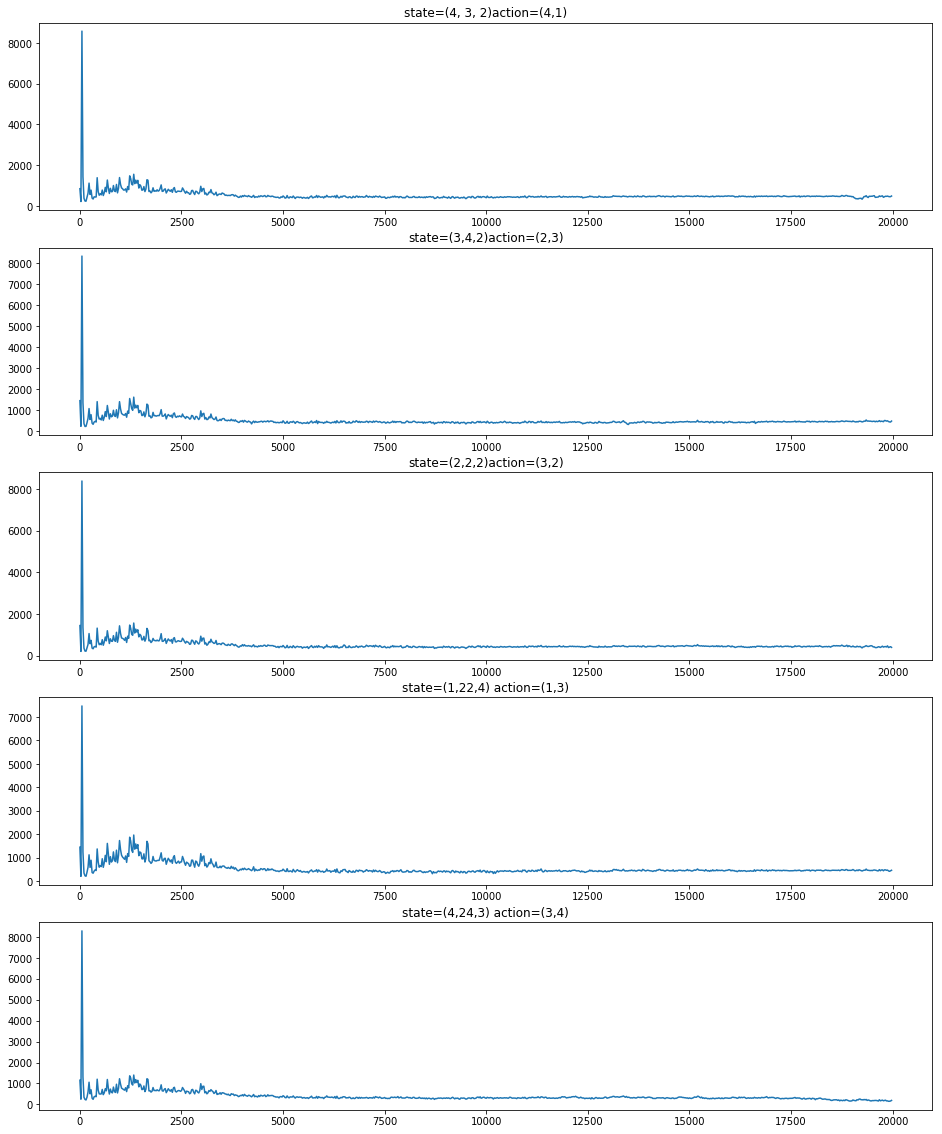

In [22]:
xaxis = list(range(0, 20000,25))

plt.figure(0, figsize=(16,20))
plt.subplot(511)
plt.title('state=(4, 3, 2)action=(4,1)')
plt.plot(xaxis,list(states_track[(4, 3, 2)].values())[0])
plt.subplot(512)
plt.title('state=(3,4,2)action=(2,3)')
plt.plot(xaxis,list(states_track[(3, 4, 2)].values())[0])
plt.subplot(513)
plt.title('state=(2,2,2)action=(3,2)')
plt.plot(xaxis,list(states_track[(2, 2, 2)].values())[0])
plt.subplot(514)
plt.title('state=(1,22,4) action=(1,3)')
plt.plot(xaxis,list(states_track[(1, 22, 4)].values())[0])
plt.subplot(515)
plt.title('state=(4,24,3) action=(3,4)')
plt.plot(xaxis,list(states_track[(4, 24, 3)].values())[0])
plt.show()

### Reward Tracking for convergence

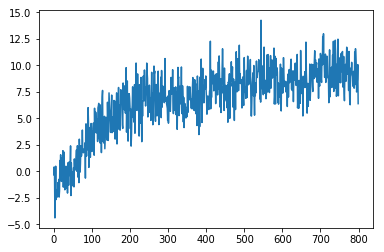

In [15]:
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.show()

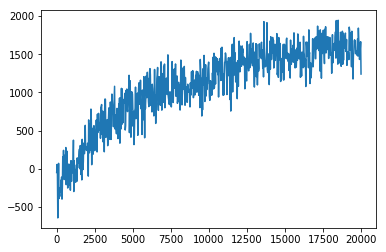

In [16]:
plt.plot(list(range(0, 20000,25)), total_reward)
plt.show()